# Doppler Scan

In [36]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from edmAnalyzer import *



import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.optimize import curve_fit

In [37]:
run = 14
sequence = 1822
offset = 18
number_of_blocks = 4
quantity_of_interest = 'Delta_Qleanup_nr'
quantity = 'N'


In [38]:

sequence = str(sequence).zfill(4)
run = str(run).zfill(4)

folderpath = r"C:\ACME_analysis\doppler"+run+"."+ sequence 
list_of_target_folders = [folderpath]

xx=hh.headerHandler(list_of_target_folders)



df = xx[[quantity_of_interest,'N','P']]   # Change this

df.to_csv(folderpath+r"\\"+r"\TiSapph_N_P.csv")
print(len(df))

def touch(folder_path):
    """
    Rename files in the specified folder from xxxx.xxxx.xxxx.bin to xxxx.xxxx.xxxx.0000.bin
    """
    for filename in os.listdir(folder_path):
        if filename.endswith('.bin') and len(filename) == 18 and filename.count('.') == 3:
            # filename is of the form xxxx.xxxx.xxxx.bin
            new_filename = filename.replace('.bin', '.0000.bin')
            source_path = os.path.join(folder_path, filename)
            target_path = os.path.join(folder_path, new_filename)

            if not os.path.exists(target_path):
                os.rename(source_path, target_path)
            else:
                print(f"Collision detected: {target_path} already exists, skipping.")

touch(folderpath)
bdf = pd.DataFrame()
bdf['Polarization Switching XY Swapped'] = [0,0,0,0,0]
NN = []
N = []
AA = []
XX = []
YY = []

for i in range(number_of_blocks):
    a = binCalculator(folderpath+r"\\"+run+"."+sequence + "." + str(i).zfill(4)+r".0000.bin", r"C:\ACMEcode\ACMEanalysis\templates\acmeiii\offsettrace\offsettrace"+str(offset)+r".json", bdf)
    a.default_pipeline()
    NN.append(a.grouped_N_total)
    N.append(a.grouped_N_total)
    AA.append(a.binresult.A)
    XX.append(a.ungrouped_Fx[:,:,:,:].sum(axis = (1,2,3)))
    YY.append(a.ungrouped_Fy[:,:,:,:].sum(axis = (1,2,3)))
AA = np.concatenate(AA)
XX = np.concatenate(XX)
YY = np.concatenate(YY)
NN = [NN[i].sum(axis = -1) for i in range(number_of_blocks)]
#Nratio = np.concatenate([NN[i]/NN[i].sum(axis = -2, keepdims = True) for i in range(number_of_blocks)])

#Nratio = np.save(folderpath + r"\Nratio.npy", Nratio)
np.save(folderpath + r"\AA.npy", AA)

128


In [39]:
N = np.concatenate([N[i].sum(axis = (1,2,3,4)) for i in range(number_of_blocks)])
df = pd.read_csv(folderpath+r"\\"+r"\TiSapph_N_P.csv")
print(np.max(N))
#df['signal'] = N/np.max(N)
if quantity == 'X':
    df['signal'] = XX/np.max(XX)
elif quantity == 'Y':
    df['signal'] = YY/np.max(YY)
elif quantity == 'N':
    df['signal'] = N/np.max(N)

121790543.53646219


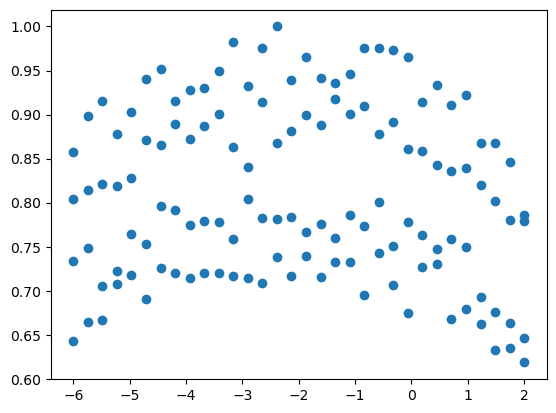

In [40]:

plt.scatter(df[quantity_of_interest], df['signal'])

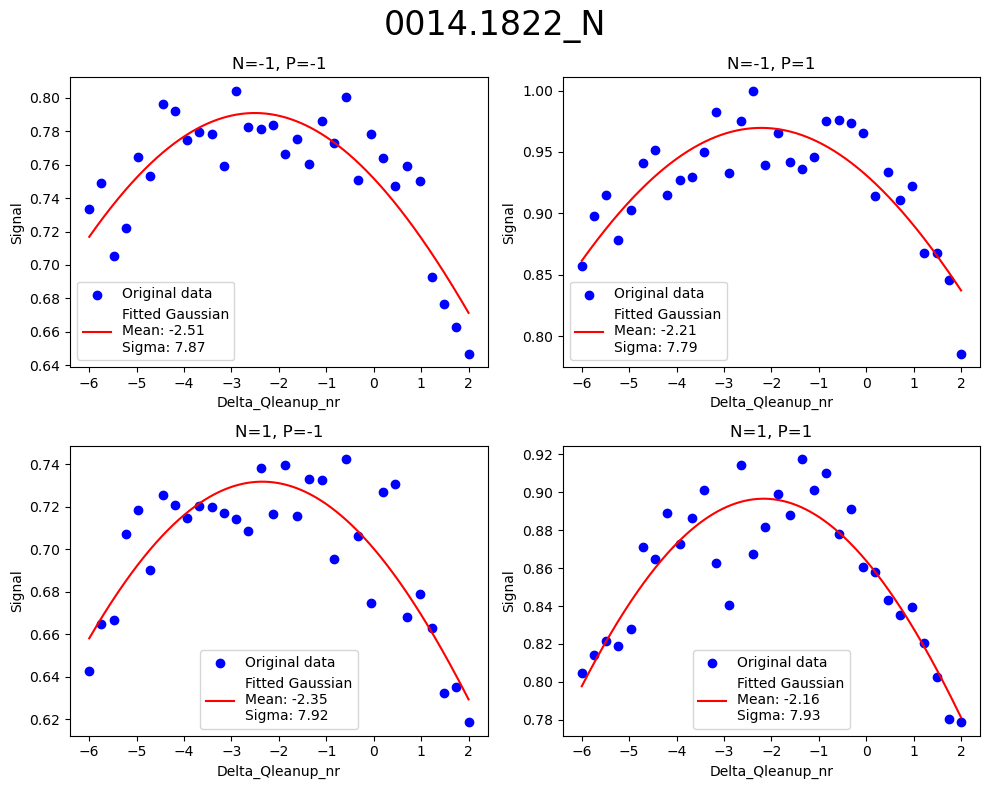

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Gaussian function with zero offset
def gaussian(x, amplitude, mean, sigma):
    return amplitude * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# Function to fit Gaussian with zero offset
def fit_gaussian(x, y):
    # Provide initial guesses for amplitude, mean, and sigma
    initial_guess = [1, 0, 2.12]
    popt, _ = curve_fit(gaussian, x, y, p0=initial_guess)
    return popt  # Return the full parameters of the Gaussian fit

# Group the DataFrame by 'N' and 'P'
grouped = df.groupby(['N', 'P'])

# Create plots for each group
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid for 4 subplots
axes = axes.ravel()
fig.suptitle(run+'.'+sequence+"_"+quantity, fontsize=24)
for i, ((N_val, P_val), group) in enumerate(grouped):
    x_data = group[quantity_of_interest]
    y_data = group['signal']
    
    # Perform Gaussian fit
    amplitude, mean, sigma = fit_gaussian(x_data, y_data)
    
    # Generate x values for plotting the fitted Gaussian curve
    x_fit = np.linspace(min(x_data), max(x_data), 1000)
    y_fit = gaussian(x_fit, amplitude, mean, sigma)
    
    # Plot original data and fitted Gaussian on the same plot
    ax = axes[i]
    ax.scatter(x_data, y_data, label='Original data', color='blue')
    ax.plot(x_fit, y_fit, label=f'Fitted Gaussian\nMean: {mean:.2f}\nSigma: {sigma:.2f}', color='red')
    ax.set_title(f'N={N_val}, P={P_val}')
    ax.set_xlabel(quantity_of_interest)
    ax.set_ylabel('Signal')
    ax.legend()

plt.tight_layout()
plt.show()


In [42]:
fig.savefig(folderpath+r"\\"+run+"."+sequence+"_"+quantity+".png")